<a href="https://colab.research.google.com/github/SofiMich/DL/blob/main/Tarea2/T2_3_Michaelian_CNNvsRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento de acciones humanas usando una red recurrente y una convolucional

Basándome en la libreta original vista en clase y usando en el conjunto [UCF11](https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php), vamos comparar el rendimiento de las arquitecturas RNN y CNN.

<img src="https://www.crcv.ucf.edu/data/youtube_snaps.jpg" width=800/>



## 1 Preparación

### 1.1 Bibliotecas

In [ ]:
# Colab
# https://github.com/TylerYep/torchinfo
!pip install torchinfo
# https://zarr.readthedocs.io/en/stable/
!pip install zarr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 5.0 MB/s 
     |████████████████████████████████| 6.6 MB 44.6 MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=77aac78a948027ed4f0722eb0d0dc9e929e4c80d5abb81e61bd65e98d578055b
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b980b8535e72a0
Successfully built asciitree


In [ ]:
# sistema de archivos
import os
# funciones aleatorias
import random
# descomprimir
import tarfile
# sistema de archivos
from os.path import join

# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
# almacenamiento de arreglos multidimensionales
import zarr
#redes
from torch.utils.data import DataLoader, random_split
# inspección de arquitectura
from torchinfo import summary

# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# tamaño del vector de características
FEAT_SIZE = 1024

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch_gen = torch.manual_seed(SEED)

# barras de progreso
from tqdm.auto import trange
from tqdm.auto import tqdm

## 2 Datos

### 2.1 Conjunto de datos

In [ ]:
class UCF11:

    def __init__(self, root, download=False):
        self.root = root
        self.zarr_dir = join(root, 'ucf11.zarr')
        if download:
            self.download()
        self.z = zarr.open(self.zarr_dir, 'r')
        self.paths = list(self.z.array_keys())
        
    def __getitem__(self, i):
        arr = self.z[self.paths[i]]
        x = np.array(arr)
        y = np.array(arr.attrs['y'], dtype=np.int64)
        return x, y

    def __len__(self):
        return len(self.paths)
    
    def _check_integrity(self):
        return os.path.isdir(self.zarr_dir)
    
    def _extract(self, root, filename):
        tar = tarfile.open(join(root, filename), "r:gz")
        tar.extractall(root)
        tar.close()

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        tvu.download_url(
            url='https://cloud.xibalba.com.mx/s/apYrNA4iM4K65o7/download',
            root=self.root,
            filename='ucf11.zarr.tar.gz',
            md5='c8a82454f9ec092d00bcd99c849e03fd'
        )
        self._extract(self.root, 'ucf11.zarr.tar.gz')

### 2.2 Instancia del conjunto y partición

In [ ]:
ds = UCF11(join(DATA_DIR, 'ucf11'), True)
x, y = ds[0]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'x [0][:5]={x[0][:5]}')
print(f'y shape={y.shape} dtype={y.dtype} {y}')
print(f'y {y}')

  0%|          | 0/53436566 [00:00<?, ?it/s]

x shape=(10, 1024) dtype=float32
x [0][:5]=[0.00022111 0.00368518 0.00314753 0.00201778 0.09296297]
y shape=() dtype=int64 0
y 0


In [ ]:
trn_size = int(0.8 * len(ds))
tst_size = len(ds) - trn_size
trn_ds, tst_ds = random_split(ds, [trn_size, tst_size])
len(trn_ds), len(tst_ds)

(1279, 320)

### 2.3 Cargadores de datos

In [ ]:
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=2
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=2
)

In [ ]:
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 10, 1024]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


## 3 Modelos

### 3.1 CNN

Bloque convolucional en este caso tendrá sólo una convolución 1d:

In [ ]:
# definición del modelo
class CNN(nn.Module):
    
    # inicializador
    def __init__(self):
        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()
        self.num_feats = 11*1024
        
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=10, out_channels=11, kernel_size=3, padding=1),
            nn.ReLU(),
        )       
        
        self.flatten = nn.Flatten()
        self.cls = nn.Linear(self.num_feats, 11)
    
    # metodo para inferencia
    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.cls(x)
        return x

In [ ]:
modelCNN = CNN().eval()
modelCNN(torch.zeros(1, 10, 1024)).shape

torch.Size([1, 11])

In [ ]:
summary(modelCNN, (1, 10, 1024), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 11]                   --
├─Sequential: 1-1                        [1, 11, 1024]             --
│    └─Conv1d: 2-1                       [1, 11, 1024]             341
│    └─ReLU: 2-2                         [1, 11, 1024]             --
├─Flatten: 1-2                           [1, 11264]                --
├─Linear: 1-3                            [1, 11]                   123,915
Total params: 124,256
Trainable params: 124,256
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.04
Forward/backward pass size (MB): 0.09
Params size (MB): 0.50
Estimated Total Size (MB): 0.63

### 3.1 RNN

Este bloque es idéntico al visto en clase salvo por un par de modificaciones:

1. Cambié la unidad recurrente nn.GRU por defecto a una nn.GRU bidireccional, así tanto los cuadros siguientes como los anteriores al cuadro correspondiente al tiempo t abonarán al contexto del cuadro t.

2. Para que los bloques RNN y CNN tengan un número similar de parámetros, cambié el número de características en el estado oculto de la RNN de 128 a 20, dado que no hay mucho que podamos hacer para modificar drásticamente el número de parámetros en la CNN con una convolución 1D. El número de parámetros entrenables en el RNN bidireccional es de 891,147, mientras que para el CNN es de 124,256. Después de hacer esta modificación, la RNN queda de 128,019 parámentros entrenables.

#### 1.3.1 Cambiando la unidad recurrente por una bidireccional:

In [ ]:
class RNN1(nn.Module):

    def __init__(self, input_size=1024, hidden_size=128, num_classes=11):
        super().__init__()
        self.bn = nn.BatchNorm1d(input_size)
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=1, batch_first=True, bidirectional = True) # bidirectional = True para hacer la unidad bidireccional (temporalmente hablando)
        self.cls = nn.Linear(2*hidden_size, num_classes)

    def forward(self, x):
        # Batch, Seq, Feats, Hidden
        # [B, S, F] => [B, F, S]
        x = x.movedim(1, 2)
        # [B, F, S]
        x = self.bn(x)
        # [B, F, S] => [B, S, F]
        x = x.movedim(1, 2)
        # [B, S, F] => [B, S, H]
        x, _ = self.rnn(x)
        # [B, S, H] => [B, H]
        # toma el último paso, participación 1
        x = x[:, -1, :]
        # [B, H] = [B, 11]
        x = self.cls(x)
        return x

In [ ]:
modelRNN1 = RNN1().eval()
modelRNN1(torch.zeros(1, 10, 1024)).shape

torch.Size([1, 11])

In [ ]:
summary(modelRNN1, (1, 10, 1024), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
RNN1                                     [1, 11]                   --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─GRU: 1-2                               [1, 10, 256]              886,272
├─Linear: 1-3                            [1, 11]                   2,827
Total params: 891,147
Trainable params: 891,147
Non-trainable params: 0
Total mult-adds (M): 8.87
Input size (MB): 0.04
Forward/backward pass size (MB): 0.10
Params size (MB): 3.56
Estimated Total Size (MB): 3.71

#### 1.3.2 Ajustando el número de parámetros:

In [ ]:
class RNN2(nn.Module):

    def __init__(self, input_size=1024, hidden_size=20, num_classes=11):
        super().__init__()
        self.bn = nn.BatchNorm1d(input_size)
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=1, batch_first=True, bidirectional = True) # bidirectional = True para hacer la unidad bidireccional (temporalmente hablando)
        self.cls = nn.Linear(2*hidden_size, num_classes)

    def forward(self, x):
        # Batch, Seq, Feats, Hidden
        # [B, S, F] => [B, F, S]
        x = x.movedim(1, 2)
        # [B, F, S]
        x = self.bn(x)
        # [B, F, S] => [B, S, F]
        x = x.movedim(1, 2)
        # [B, S, F] => [B, S, H]
        x, _ = self.rnn(x)
        # [B, S, H] => [B, H]
        # toma el último paso, participación 1
        x = x[:, -1, :]
        # [B, H] = [B, 11]
        x = self.cls(x)
        return x

In [ ]:
modelRNN2 = RNN2().eval()
modelRNN2(torch.zeros(1, 10, 1024)).shape

torch.Size([1, 11])

In [ ]:
summary(modelRNN2, (1, 10, 1024), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
RNN2                                     [1, 11]                   --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─GRU: 1-2                               [1, 10, 40]               125,520
├─Linear: 1-3                            [1, 11]                   451
Total params: 128,019
Trainable params: 128,019
Non-trainable params: 0
Total mult-adds (M): 1.26
Input size (MB): 0.04
Forward/backward pass size (MB): 0.09
Params size (MB): 0.51
Estimated Total Size (MB): 0.64

## 4 Entrenamiento

In [ ]:
def entrenar(modelo, EPOCHS = 15):
  opt = optim.Adam(modelo.parameters(), lr=1e-4)

  exactitud = []
  perdida = []

  # ciclo de entrenamiento
  for epoch in range(EPOCHS):

      # modelo en modo de entrenamiento
      modelo.train()
    
      # entrenamiento de una época
      for x, y_true in trn_dl:
          # hacemos inferencia para obtener los logits
          y_lgts = modelo(x)
          # calculamos la pérdida
          loss = F.cross_entropy(y_lgts, y_true)
          # vaciamos los gradientes
          opt.zero_grad()
          # retropropagamos
          loss.backward()
          # actulizamos parámetros
          opt.step()

      # desactivamos temporalmente la gráfica de cómputo
      with torch.no_grad():

          # modelo en modo de evaluación
          modelo.eval()
        
          losses, accs = [], []
          # validación de la época
          for x, y_true in tst_dl:
              # hacemos inferencia para obtener los logits
              y_lgts = modelo(x)
              # calculamos las probabilidades
              y_prob = F.softmax(y_lgts, 1)
              # obtenemos la clase predicha
              y_pred = torch.argmax(y_prob, 1)
            
              # calculamos la pérdida
              loss = F.cross_entropy(y_lgts, y_true)
              # calculamos la exactitud
              acc = (y_true == y_pred).type(torch.float32).mean()

              # guardamos históricos
              losses.append(loss.item() * 100)
              accs.append(acc.item() * 100)

          # imprimimos métricas
          loss = np.mean(losses)
          acc = np.mean(accs)
          exactitud.append(acc)
          perdida.append(loss)
          print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')

  return exactitud, perdida

In [ ]:
exactitudCNN, perdidaCNN = entrenar(modelCNN, 100)

E 0 loss=231.20 acc=22.50
E 1 loss=226.83 acc=21.88
E 2 loss=220.94 acc=26.25
E 3 loss=217.05 acc=29.69
E 4 loss=211.44 acc=29.38
E 5 loss=208.78 acc=29.69
E 6 loss=203.50 acc=33.44
E 7 loss=200.66 acc=34.06
E 8 loss=196.86 acc=35.31
E 9 loss=194.68 acc=37.81
E10 loss=190.40 acc=39.06
E11 loss=187.60 acc=39.06
E12 loss=184.79 acc=41.25
E13 loss=184.33 acc=40.62
E14 loss=179.83 acc=42.19
E15 loss=182.44 acc=40.00
E16 loss=178.30 acc=43.44
E17 loss=178.50 acc=45.31
E18 loss=175.34 acc=44.06
E19 loss=175.02 acc=43.12
E20 loss=173.17 acc=44.38
E21 loss=172.96 acc=43.75
E22 loss=170.45 acc=47.19
E23 loss=169.50 acc=44.06
E24 loss=168.40 acc=46.56
E25 loss=166.80 acc=45.31
E26 loss=168.07 acc=45.94
E27 loss=169.46 acc=45.94
E28 loss=165.51 acc=46.88
E29 loss=164.96 acc=47.81
E30 loss=163.18 acc=48.12
E31 loss=162.50 acc=47.81
E32 loss=164.25 acc=47.81
E33 loss=162.26 acc=48.75
E34 loss=161.18 acc=46.88
E35 loss=161.50 acc=45.94
E36 loss=164.33 acc=47.50
E37 loss=161.25 acc=48.75
E38 loss=160

In [ ]:
exactitudRNN1, perdidaRNN1 = entrenar(modelRNN1, 100)

E 0 loss=229.02 acc=20.94
E 1 loss=217.58 acc=26.56
E 2 loss=210.21 acc=29.38
E 3 loss=204.51 acc=34.38
E 4 loss=200.35 acc=36.25
E 5 loss=196.39 acc=38.75
E 6 loss=193.64 acc=40.94
E 7 loss=190.78 acc=42.19
E 8 loss=187.45 acc=41.88
E 9 loss=184.97 acc=42.19
E10 loss=182.52 acc=42.81
E11 loss=180.13 acc=43.75
E12 loss=178.02 acc=44.06
E13 loss=176.09 acc=44.06
E14 loss=174.63 acc=44.38
E15 loss=172.55 acc=45.00
E16 loss=170.21 acc=46.25
E17 loss=169.30 acc=45.94
E18 loss=166.68 acc=47.19
E19 loss=165.44 acc=47.19
E20 loss=163.43 acc=47.81
E21 loss=162.34 acc=48.12
E22 loss=160.79 acc=48.44
E23 loss=159.63 acc=49.38
E24 loss=158.67 acc=48.75
E25 loss=157.71 acc=48.44
E26 loss=156.37 acc=49.38
E27 loss=155.43 acc=49.06
E28 loss=153.81 acc=50.94
E29 loss=154.00 acc=50.94
E30 loss=153.50 acc=49.38
E31 loss=152.40 acc=50.31
E32 loss=151.57 acc=50.31
E33 loss=150.75 acc=52.50
E34 loss=150.91 acc=50.94
E35 loss=149.95 acc=51.88
E36 loss=149.73 acc=51.25
E37 loss=148.60 acc=52.19
E38 loss=148

In [ ]:
exactitudRNN2, perdidaRNN2 = entrenar(modelRNN2, 100)

E 0 loss=245.28 acc=6.88
E 1 loss=239.52 acc=13.44
E 2 loss=236.02 acc=16.88
E 3 loss=233.74 acc=17.50
E 4 loss=231.61 acc=18.12
E 5 loss=230.14 acc=20.00
E 6 loss=228.48 acc=20.62
E 7 loss=227.49 acc=20.62
E 8 loss=225.70 acc=21.25
E 9 loss=224.25 acc=21.88
E10 loss=223.24 acc=22.81
E11 loss=222.37 acc=23.75
E12 loss=221.33 acc=24.69
E13 loss=220.43 acc=25.00
E14 loss=219.43 acc=25.62
E15 loss=218.63 acc=26.88
E16 loss=217.51 acc=27.19
E17 loss=216.68 acc=26.88
E18 loss=215.62 acc=27.50
E19 loss=214.67 acc=28.44
E20 loss=213.92 acc=29.38
E21 loss=213.30 acc=29.06
E22 loss=212.57 acc=29.06
E23 loss=211.98 acc=30.31
E24 loss=211.25 acc=30.31
E25 loss=210.76 acc=31.25
E26 loss=210.20 acc=32.19
E27 loss=208.99 acc=30.94
E28 loss=208.72 acc=30.62
E29 loss=207.76 acc=31.56
E30 loss=207.20 acc=31.56
E31 loss=206.57 acc=31.56
E32 loss=205.89 acc=31.25
E33 loss=205.50 acc=32.19
E34 loss=204.50 acc=33.12
E35 loss=204.33 acc=31.56
E36 loss=203.38 acc=31.88
E37 loss=203.30 acc=32.50
E38 loss=202.

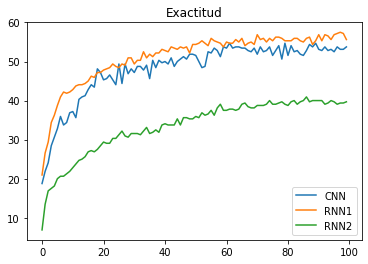

In [ ]:
import matplotlib.pyplot as plt
plt.title('Exactitud')
plt.plot(exactitudCNN, label = "CNN")
plt.plot(exactitudRNN1, label = "RNN1")
plt.plot(exactitudRNN2, label = "RNN2")
plt.legend()
plt.show()

Vemos que la red recurrente con el número de parámetros original tiene el mejor rendimiento, seguida de la convolucional con solo una capa, mientras qu muy por debajo de las dos se encuentra la recurrente con el número de parámetros diminuido.

Podemos concluir de aquí que el poder de la red recurrente se encuentra justamente en los parámetros ocultos que se encargan de transmitir la dependencia temporal de los cuadros.

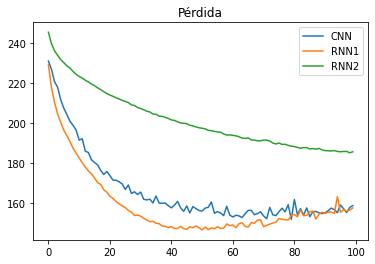

In [ ]:
plt.title('Pérdida')
plt.plot(perdidaCNN, label = "CNN")
plt.plot(perdidaRNN1, label = "RNN1")
plt.plot(perdidaRNN2, label = "RNN2")
plt.legend()
plt.show()

Si nos fijamos en la pérdia, observamos que el patrón antes mencionado (RNN2 mejor que RNN1 mejor que CNN) se mantiene, sin embargo alGo cuirioso empieza a suceder con la red recurrente RNN2: la pérdida comienza a subir después de su mínimo (al rededor de la época 40). Esto puede ser porque la tasa de aprendizaje definida al principio es muy grande para este punto, y en vez de converger, el modelo empieza a "salirse" del mínimo. Para probar la hipótesis tendríamos que escoger una taza de aprendizaje más pequeña e iterar durante más épocas.